# 1. Top 3 most cited papers of each Conference

Below is the code to extract the most cited Articles of each Conference. Given our model, we will smoothly traverse through an article to the Conference it belongs to thanks to the flexibility of Neo4j. To do so, we first match all nodes, then easily count how many citations each paper has thanks to the "has_citations" node we designed. Once we have such data, we proceed to collect the top 3 articles per conference, and unwind the results to present them. 

```bash
// 1. Traverse from article → booktitle → proceedings → edition → conference
MATCH 
  (p:article)
    -[:PRESENTED_AT]->(bt:booktitle)
    <-[:PRESENTED_AT]-(pr:proceedings)
    -[:of_edition]->(ed:ConferenceEdition)
    -[:PART_OF]->(c:Conference)

// 2. Count citations per paper
OPTIONAL MATCH 
  (:article)-[:HAS_CITATION]->(p)
WITH
  c.name         AS conference,
  bt.title       AS booktitle,
  p.title        AS paper,
  count(*)       AS citations

// 3. Collect top 3 by citation per conference
ORDER BY conference, citations DESC
WITH
  conference,
  collect({booktitle:booktitle, paper:paper, cites:citations})[0..3] AS top3

// 4. Unwind and present
UNWIND top3 AS row
RETURN
  conference,
  row.booktitle  AS edition,
  row.paper      AS paper,
  row.cites      AS citations
ORDER BY
  conference,
  row.cites DESC;


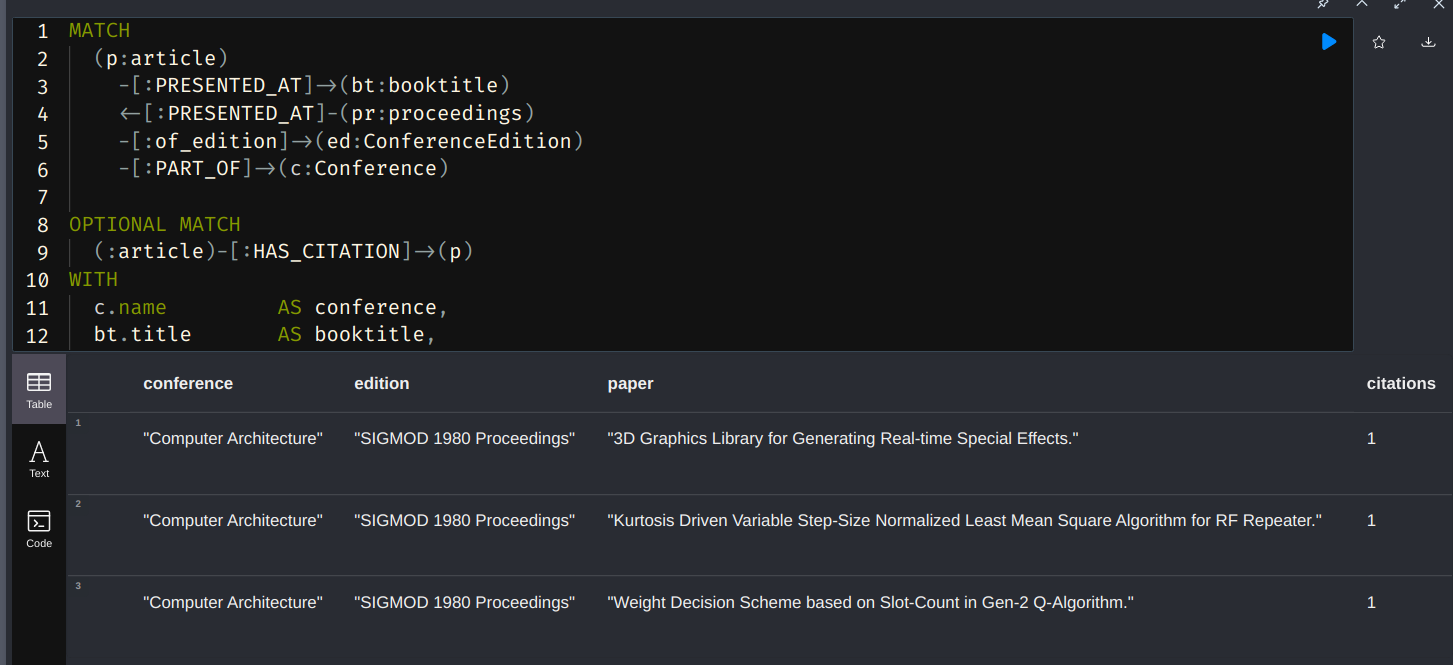

# 2. Conference Community

To make the following query as efficient as possible, we follow the procedure below. We first match the nodes affected during the traverse (the same as in the previous query, adding the author), and then match only the authors that have made an article publication to 4 different Editions of the same Conference. 

```bash
MATCH 
  (a:author)<-[:authored_by]-(art:article)
  -[:PRESENTED_AT]->(bt:booktitle)
  <-[:PRESENTED_AT]-(pr:proceedings)
  -[:of_edition]->(ed:ConferenceEdition)
  -[:part_of]->(c:Conference)
WITH 
  c.name             AS conference,
  a.name             AS author,
  count(DISTINCT ed) AS editionsCount
WHERE editionsCount >= 4
RETURN
  conference,
  author,
  editionsCount
ORDER BY
  conference,
  editionsCount DESC,
  author;


![Screenshot from 2025-04-25 08-58-00.png](<attachment:Screenshot from 2025-04-25 08-58-00.png>)
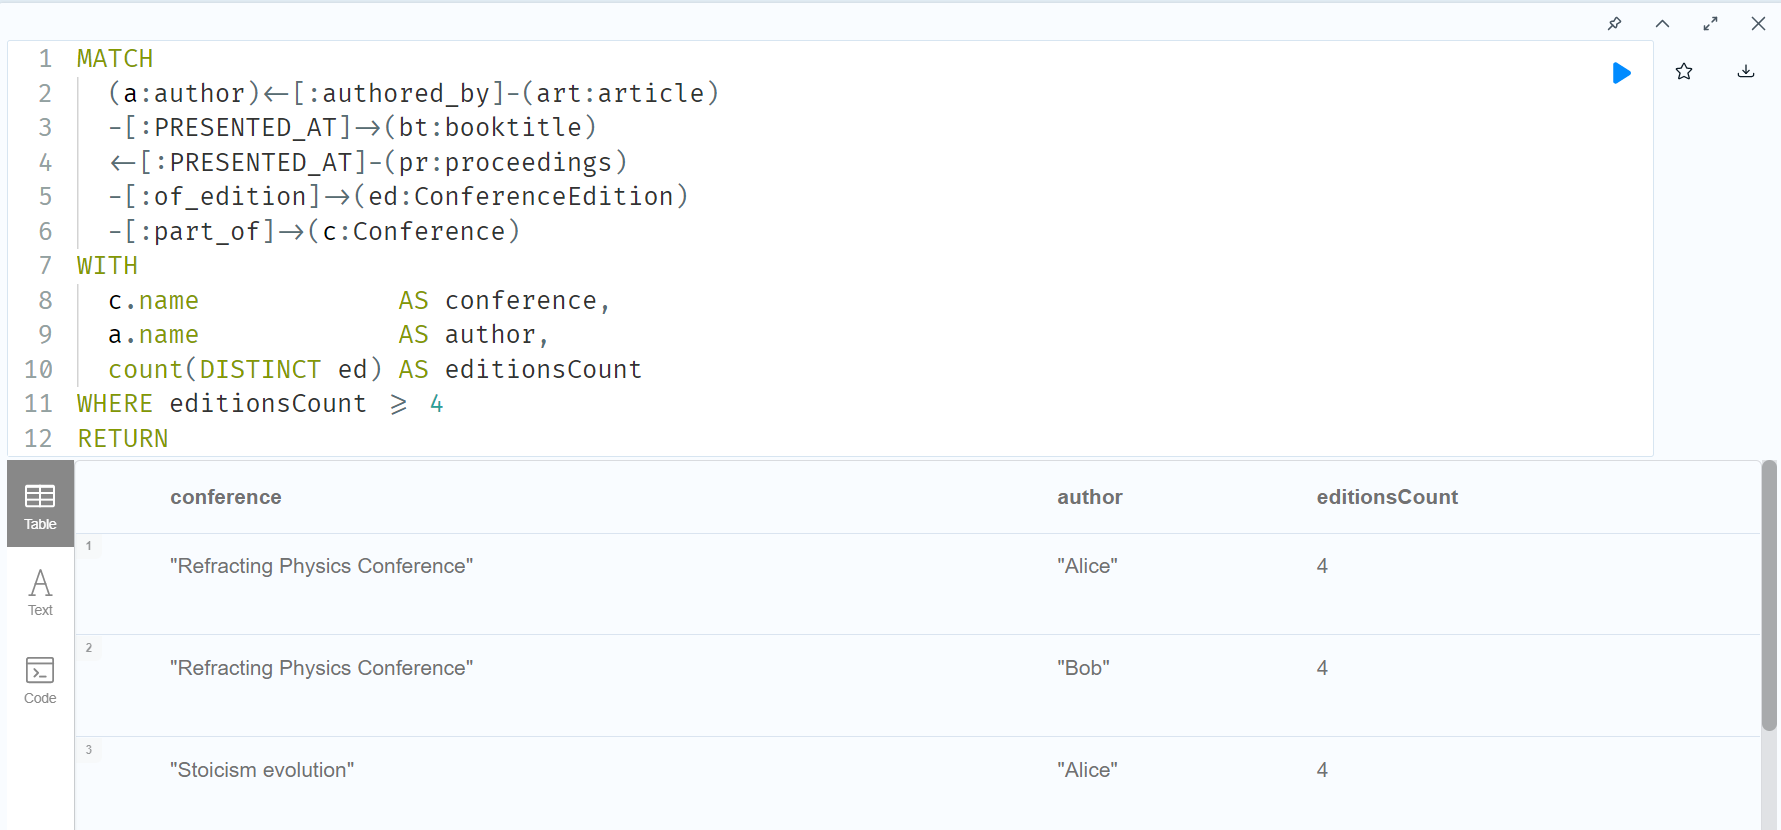

# 3. Impact Factor of journals

Before writing the query, lets recall how the calculation of an impact factor is copmuted. "In any given year, the two-year journal impact factor is the ratio between the number of citations received in that year for publications in that journal that were published in the two preceding years and the total number of "citable items" published in that journal during the two preceding years"

To be able to run this query, we first need to define a target year. To make the query as efficient as possible, we create a parameter that we can later change for another one and re run the query rapidly. The pipeline is as follows: 

Once we have defined the year and matched all journals, we proceed to first calculate how many papers were published during the two years previous to our target year. Afterwards, we proceed to count the number of citations made **in that year only**, to the articles published in the two previous years. Once we have both numerator and denominator, we can then calculate the result and return in nicely. 

```bash
// 1) set the target year
:param year => 2024;

// 2) compute impact factor per journal
MATCH (j:journal)
WITH j

// Denominator: count of articles the journal published in (year−2) and (year−1)
OPTIONAL MATCH (j)<-[:PUBLISHED_IN]-(p:article)
WHERE p.year IN [ $year - 2, $year - 1 ]
WITH j, count(p) AS numPapers

// Numerator: count of citations *made in $year* to those papers
OPTIONAL MATCH (j)<-[:PUBLISHED_IN]-(cited:article)<-[:HAS_CITATION]-(citer:article)
WHERE cited.year IN [ $year - 2, $year - 1 ]
  AND citer.year = $year
WITH j, numPapers, count(*) AS numCitations

// Final result: impact factor = numCitations / numPapers
WHERE numPapers > 0
RETURN
  j.name                AS journal,
  $year                 AS year,
  round(toFloat(numCitations) / numPapers, 3) AS impactFactor,
  numCitations,
  numPapers
ORDER BY impactFactor DESC;


![Screenshot from 2025-04-25 09-00-49.png](<attachment:Screenshot from 2025-04-25 09-00-49.png>)
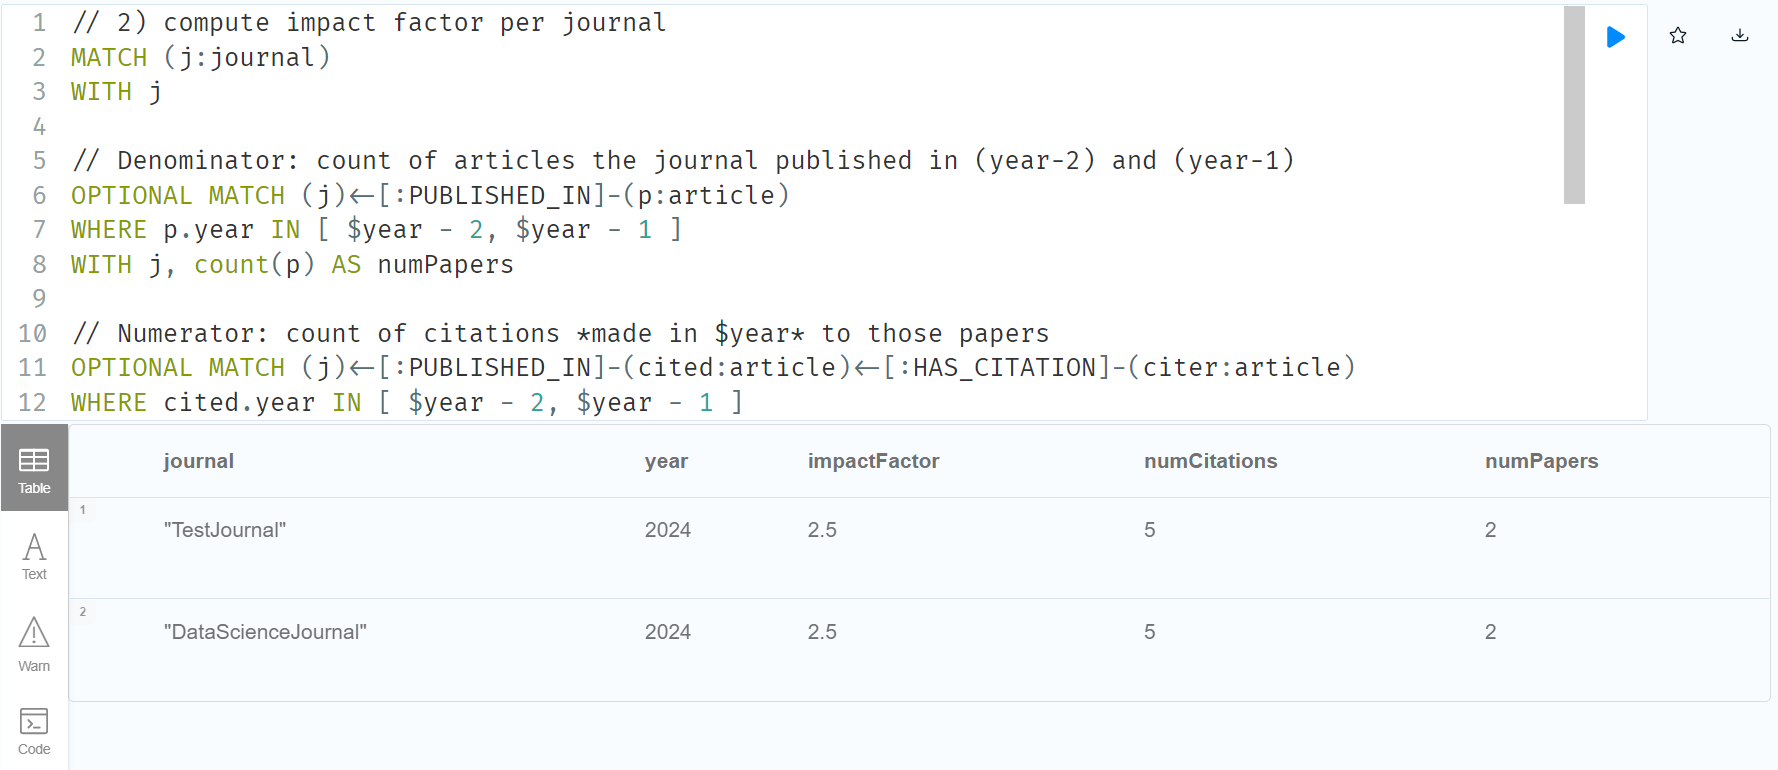

# 4. H-Index of authors in the graph

This query calculates the h-index for each author by using a subquery to process one author at a time, which makes it memory-efficient and avoids loading the entire dataset into memory. 

For each author, the subquery matches all articles they have authored and counts how many times each article has been cited. These citation counts are then collected and sorted in descending order. The query then iterates through the sorted list, incrementing a counter as long as the number of citations at each position is greater than or equal to the position index. The final result is the highest index at which this condition holds, which is the author's h-index. This method allows for each author’s data to be handled independently and scales well with large amount of data, contrary to previous queries we designed - which were computationally too expensive. 

```bash
// compute h-index per author, one author at a time
MATCH (a:author)
CALL {
  WITH a
  // 1) for this author, pull each of their papers and its citation count
  MATCH (a)<-[:authored_by]-(p:article)
  OPTIONAL MATCH (p)<-[:HAS_CITATION]-(:article)
  WITH p, count(*) AS c
  // 2) order descending so the biggest counts come first
  ORDER BY c DESC
  WITH collect(c) AS citationList
  // 3) fold into a running h-index
  RETURN
    reduce(
      h = 0,
      c IN citationList |
        CASE WHEN c > h THEN h + 1 ELSE h END
    ) AS hIndex
}
RETURN
  a.name   AS author,
  hIndex
ORDER BY
  hIndex DESC,
  author;



![Captura de pantalla 2025-04-25 162758.png](Last_query)